In [1]:
# pycuda, numpy, scipy, matplotlib
import os
os.environ["CUDA_DEVICE"] = "3"

import sys
sys.path.append('../')
sys.path.append('../old/')
from pycuda.autoinit import context
import pycuda.driver as drv
from pycuda import cumath
from pycuda import gpuarray
from scipy.optimize import curve_fit
import numpy as np
import matplotlib.pyplot as plt
from scipy.constants import e, epsilon_0

from pypic import PyPIC_GPU as PIC
from meshing import RectMesh2D
from poisson_solver import FFT_solver as FFT


import FFT_OpenBoundary_SquareGrid as PIC_old
import geom_impact_poly as poly
import geom_impact_ellip as ell

%matplotlib inline

PyKLU not found


## define mesh, poisson solver and pic

In [2]:
nx, ny = 128, 128
dx = dy = 0.04
x_aper = nx*dx/2.
y_aper = ny*dy/2.
mesh = RectMesh2D(-x_aper, -y_aper, dx, dy, nx, ny, mathlib=cumath)

In [3]:
poissonsolver = FFT.GPUFFTPoissonSolver(mesh)
pic = PIC(mesh, poissonsolver, context=context)

{'p2m': {'grid': (0, 1, 1), 'block': (16, 16, 1)}, 'm2p': {'grid': (0, 1, 1), 'block': (16, 16, 1)}, 'sorted_p2m': {'grid': (64, 1, 1), 'block': (256, 1, 1)}}
max_nodes 1024


## generate particles
make sure they're inside the mesh boundaries

In [4]:
N = 100000
np.random.seed(0)
mesh_center_x = mesh.x0 + 0.5*mesh.nx*mesh.dx
mesh_center_y = mesh.y0 + 0.5*mesh.ny*mesh.dy
sigma = 0.4
xx = np.random.normal(mesh_center_x, sigma, N)
yy = np.random.normal(mesh_center_y, sigma, N)
assert((xx > mesh.x0).all() and (xx < mesh.x0 + mesh.nx*mesh.dx).all())
assert((yy > mesh.y0).all() and (yy < mesh.y0 + mesh.ny*mesh.dy).all())
xx = gpuarray.to_gpu(xx)
yy = gpuarray.to_gpu(yy)

### convenience wrapper which runs the pic and stores all intermediate results

In [5]:
def test_solver(new_solver, xx, yy, charge=e, x_probe=None, y_probe=None, z_probe=None):
    '''
    Return rho, Phi, efx, efy, Ex, Ey
    '''
    if x_probe == None:
        x_probe = xx
    if y_probe == None:
        y_probe = yy
    mesh_charges = new_solver.particles_to_mesh(xx, yy, charge=charge)
    rho = mesh_charges/new_solver.mesh.volume_elem
    phi = new_solver.poisson_solve(rho)
    mesh_e_fields = new_solver.get_electric_fields(phi)
    efx = mesh_e_fields[0]
    efy = mesh_e_fields[1]
    mesh_fields_and_mp_coords = zip(list(mesh_e_fields), [x_probe, y_probe])
    fields = new_solver.field_to_particles(*mesh_fields_and_mp_coords)
    Ex = fields[0]
    Ey = fields[1]
    return rho, phi, efx, efy, Ex, Ey

## Run the pic and store the results

In [6]:
rho, phi, efx, efy, Ex, Ey = test_solver(pic, xx, yy)
np.allclose(Ex.get(), pic.pic_solve(xx,yy)[0].get())

True

### Run the old solver for comparison

In [7]:
pic_old = PIC_old.FFT_OpenBoundary_SquareGrid(x_aper=x_aper, y_aper=y_aper, Dh = mesh.dx, fftlib='pyfftw')
nel_part = np.zeros(len(xx.get()))+1
pic_old.scatter(xx.get(), yy.get(), nel_part, charge=e)
pic_old.solve()

Start PIC init.:
FFT, Open Boundary, Square Grid
PyPIC Version 1.02
Using PyFFTW


### Analytical solution for a round beam in free space

In [8]:
def _phin_round(x, y, sig_r):
    '''Return phi / Q for a point charge at (0,0). Should yield the same results for r > 3*sigma
    '''
    r = np.sqrt(x**2 + y**2 )
    return (-1)*np.log(r)/ (2*np.pi*epsilon_0)

from scipy.special import erf
extent = np.array([mesh.x0, mesh.x0+mesh.nx*mesh.dx,
                   mesh.y0, mesh.y0+mesh.ny*mesh.dy])
y, x = np.meshgrid(   np.linspace(extent[2], extent[3], mesh.ny),
                      np.linspace(extent[0], extent[1], mesh.nx),
                      indexing="ij")
xr = x - mesh_center_x - 0.5*mesh.dx
yr = y - mesh_center_y - 0.5*mesh.dy
sig_x = sigma
phi_analytic = _phin_round(xr, yr, sig_x) * N * e

## Plot the results

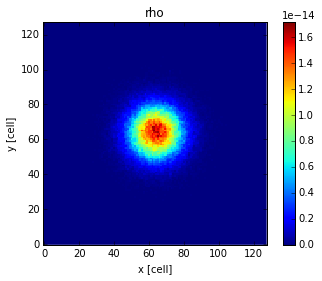

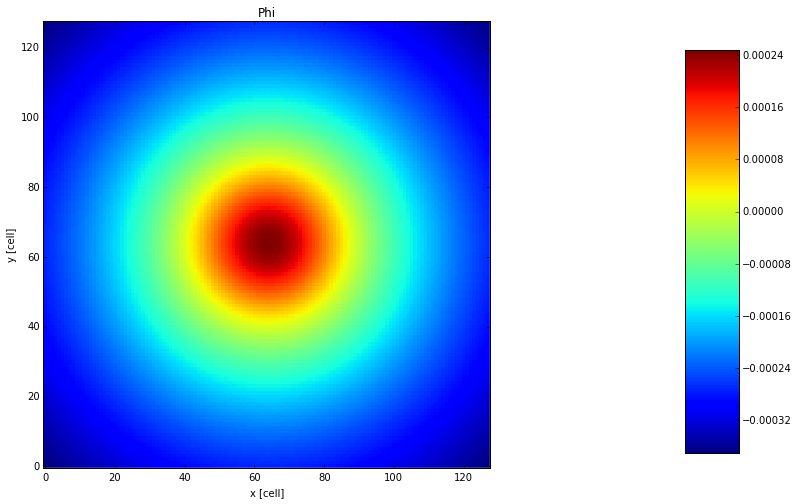

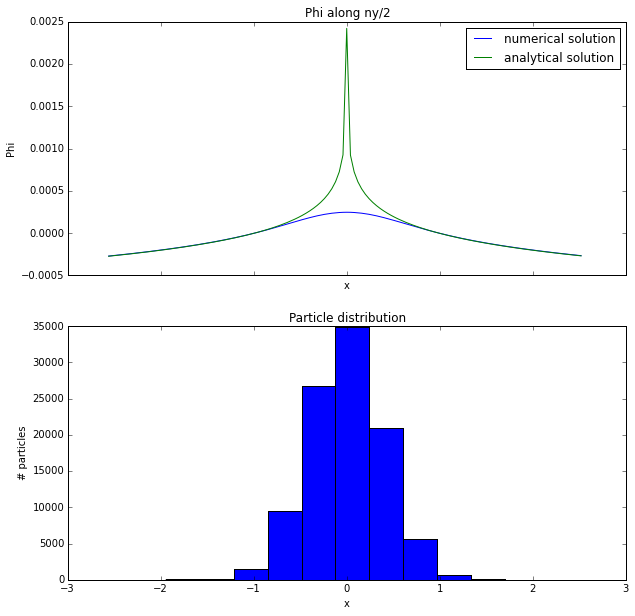

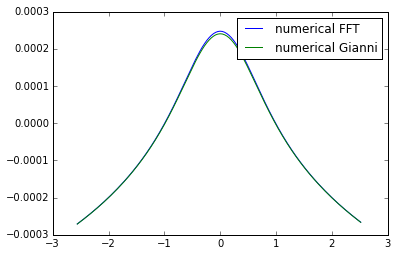

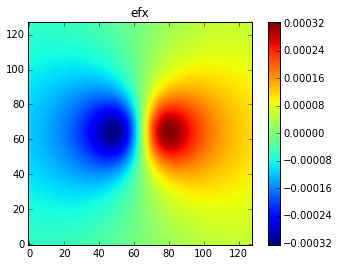

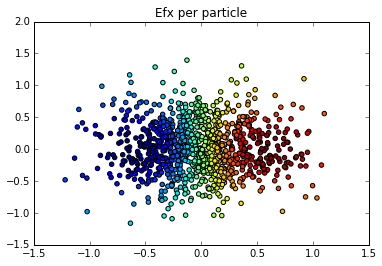

In [9]:
# rho
plt.figure()
plt.imshow(rho.get(), origin='lower', interpolation='none')
plt.colorbar()
plt.title('rho')
plt.xlabel('x [cell]')
plt.ylabel('y [cell]')
plt.show()

# Phi 2d
f = plt.figure()
f.set_figheight(8)
f.set_figwidth(15)
im =plt.imshow(phi.get(), origin='lower', interpolation='none')
plt.title('Phi')
plt.xlabel('x [cell]')
plt.ylabel('y [cell]')
f.subplots_adjust(right=0.8)
cbar_ax = f.add_axes([0.85, 0.15, 0.05, 0.7])
f.colorbar(im, cax=cbar_ax)
plt.show()

# Phi compare with analytical results and a 1/r fit
def fn(r, a):
    '''Analytical solution fit'''
    return a*1./np.log(r)

xxx = np.arange(mesh.x0, mesh.x0+mesh.nx*mesh.dx, dx)
start_fit = mesh.nx/2 + 4
fit_xxx = xxx[start_fit:]
#popt_GPU, _ = curve_fit(fn, fit_xxx, phi.get()[mesh.ny//2, start_fit:])
f, axarr = plt.subplots(2, sharex=True)
f.set_figheight(10)
f.set_figwidth(10)
axarr[0].set_title('Phi along ny/2')
axarr[0].plot(xxx,phi.get()[mesh.ny//2,:],label = 'numerical solution')
axarr[0].plot(xxx, phi_analytic[mesh.ny//2, :], label= 'analytical solution')
#axarr[0].plot(fit_xxx, fn(fit_xxx, *popt_GPU), label='log fit')
axarr[0].set_ylabel('Phi')
axarr[0].set_xlabel('x')

axarr[0].legend()
axarr[1].set_title('Particle distribution')
axarr[1].hist(xx.get())
axarr[1].set_xlabel('x')
axarr[1].set_ylabel('# particles')

plt.show()

plt.figure()
plt.plot(xxx, phi.get()[mesh.ny//2,:], label='numerical FFT')
plt.plot(xxx, pic_old.phi.T[mesh.ny//2,4:-5], label='numerical Gianni')
plt.legend()
plt.show()

plt.figure()
plt.imshow(efx.get(), origin='lower')
plt.title('efx')
plt.colorbar()
plt.show()

plt.figure()
plt.title('Efx per particle')
plt.scatter(xx.get()[0:1000],yy.get()[0:1000], c=Ex.get()[0:1000])
plt.show()